In [1]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

import gym.spaces
import gym
import FastSLAM

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler

In [2]:
N_eps = 500
sim_time = 10.0
gamma = 0.9
_render = False
log_interval = 10
state_size = 12

TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward', 'score'])
Transition = namedtuple('Transition', ['s', 'a', 'a_log_p', 'r', 's_'])

In [3]:
class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.mu_head = nn.Linear(100, 1)
        self.sigma_head = nn.Linear(100, 1)

    def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        mu = self.mu_head(x)
        sigma = F.sigmoid(self.sigma_head(x))
        return (mu, sigma)


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.v_head = nn.Linear(100, 1)

    def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        state_value = self.v_head(x)
        return state_value

In [4]:
class Agent():

    clip_param = 0.2
    max_grad_norm = 0.5
    ppo_epoch = 10
    buffer_capacity, batch_size = 1000, 32

    def __init__(self):
        self.training_step = 0
        self.anet = ActorNet().float()
        self.cnet = CriticNet().float()
        self.buffer = []
        self.counter = 0

        self.optimizer_a = optim.Adam(self.anet.parameters(), lr=1e-4)
        self.optimizer_c = optim.Adam(self.cnet.parameters(), lr=3e-4)

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            (mu, sigma) = self.anet(state)
        dist = Normal(mu, sigma)
        action = dist.sample()
        action_log_prob = dist.log_prob(action)
#         action.clamp(-2.0, 2.0)
        return action.item(), action_log_prob.item(), mu.numpy()[0][0], sigma.numpy()[0][0]

    def get_value(self, state):

        state = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            state_value = self.cnet(state)
        return state_value.item()

    def store(self, transition):
        self.buffer.append(transition)
        self.counter += 1
        return self.counter % self.buffer_capacity == 0

    def update(self):
        self.training_step += 1

        s = torch.tensor([t.s for t in self.buffer], dtype=torch.float)
        a = torch.tensor([t.a for t in self.buffer], dtype=torch.float).view(-1, 1)
        r = torch.tensor([t.r for t in self.buffer], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in self.buffer], dtype=torch.float)

        old_action_log_probs = torch.tensor(
            [t.a_log_p for t in self.buffer], dtype=torch.float).view(-1, 1)

        r = (r - r.mean()) / (r.std() + 1e-5)
        with torch.no_grad():
            target_v = r + gamma * self.cnet(s_)

        adv = (target_v - self.cnet(s)).detach()

        for _ in range(self.ppo_epoch):
            for index in BatchSampler(
                    SubsetRandomSampler(range(self.buffer_capacity)), self.batch_size, False):

                (mu, sigma) = self.anet(s[index])
                dist = Normal(mu, sigma)
                action_log_probs = dist.log_prob(a[index])
                ratio = torch.exp(action_log_probs - old_action_log_probs[index])

                surr1 = ratio * adv[index]
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param,
                                    1.0 + self.clip_param) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()

                self.optimizer_a.zero_grad()
                action_loss.backward()
                nn.utils.clip_grad_norm_(self.anet.parameters(), self.max_grad_norm)
                self.optimizer_a.step()

                value_loss = F.smooth_l1_loss(self.cnet(s[index]), target_v[index])
                self.optimizer_c.zero_grad()
                value_loss.backward()
                nn.utils.clip_grad_norm_(self.cnet.parameters(), self.max_grad_norm)
                self.optimizer_c.step()

        del self.buffer[:]

In [5]:
# env = gym.make('Pendulum-v0')

# agent = Agent()

# training_records = []
# running_reward = -1000
# state = env.reset()
# for i_ep in range(1000):
#     score = 0
#     state = env.reset()

#     for t in range(200):
#         action, action_log_prob = agent.select_action(state)
#         state_, reward, done, _ = env.step([action])
#         if _render:
#             env.render()
#         if agent.store(Transition(state, action, action_log_prob, reward, state_)):
#             agent.update()
#         score += reward
#         state = state_

#     running_reward = running_reward * 0.9 + score * 0.1
#     training_records.append(TrainingRecord(i_ep, running_reward, score))

#     if i_ep % log_interval == 0:
#         print('Ep {}\tMoving average score: {:.2f}\t'.format(i_ep, running_reward))
#     if running_reward > -200:
#         print("Solved! Moving average score is now {}!".format(running_reward))
#         env.close()
#         break

In [6]:
env = gym.make('FastSLAM-v0')

agent = Agent()

training_records = []
running_reward = 0
state = env.reset()
for i_ep in range(N_eps):
    score = 0
    state = env.reset()

    while env.time < sim_time:
        action, action_log_prob, _, _ = agent.select_action(state)
        state_, reward, done, _ = env.step([action])
        if _render:
            env.render_world()
            display.clear_output(wait=True)
            plt.pause(0.001)
        if agent.store(Transition(state, action, action_log_prob, reward, state_)):
            agent.update()
        score += reward
        state = state_

    running_reward = running_reward * 0.9 + score * 0.1
    training_records.append(TrainingRecord(i_ep, running_reward, score))

    if i_ep % log_interval == 0:
        print('Ep {}\tMoving average score: {:.2f}\t'.format(i_ep, running_reward))

/home/ggrg/Documents/gym/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Ep 0	Moving average score: 0.52	
Ep 10	Moving average score: 123.10	
Ep 20	Moving average score: 160.62	
Ep 30	Moving average score: 99.40	
Ep 40	Moving average score: 102.01	
Ep 50	Moving average score: 140.83	
Ep 60	Moving average score: 130.58	
Ep 70	Moving average score: 233.17	
Ep 80	Moving average score: 152.80	
Ep 90	Moving average score: 285.49	
Ep 100	Moving average score: 259.66	
Ep 110	Moving average score: 247.24	
Ep 120	Moving average score: 323.74	
Ep 130	Moving average score: 185.35	
Ep 140	Moving average score: 282.62	
Ep 150	Moving average score: 200.45	
Ep 160	Moving average score: 190.39	
Ep 170	Moving average score: 328.24	
Ep 180	Moving average score: 576.82	
Ep 190	Moving average score: 465.09	
Ep 200	Moving average score: 303.06	
Ep 210	Moving average score: 207.25	
Ep 220	Moving average score: 251.96	
Ep 230	Moving average score: 381.07	
Ep 240	Moving average score: 322.85	
Ep 250	Moving average score: 343.23	
Ep 260	Moving average score: 375.45	
Ep 270	Moving a

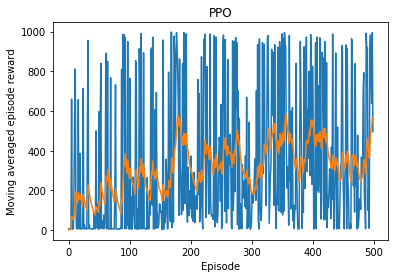

In [7]:
# env.close()
plt.plot([r.ep for r in training_records], [r.score for r in training_records])
plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
plt.title('PPO')
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()

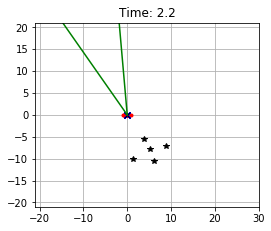

In [ ]:
# env = gym.make('FastSLAM-v0')
# agent = Agent()
state = env.reset()
a_, r_, mu_, sigma_, _state_ = [], [], [], [], []

while env.time < sim_time:
    _state_.append(state)
#     print(state)
    action, action_log_prob, mu, sigma = agent.select_action(state)
    state_, reward, done, _ = env.step([action])
    a_.append([action])
    r_.append(reward)
    mu_.append(mu)
    sigma_.append(sigma)
    state = state_
    env.render_world()
    display.clear_output(wait=True)
    plt.pause(0.001)
    

In [15]:
sum(r_)

588.1897550003099